## Deep Learning

## Project 2: Build a Traffic Sign Recognition Classifier

In this project, we will us tensorflow and a convolutional neural net deep learning architecture based on LeNet to classify traffic sign images. 

---
## Step 1: Load The Data


In [1]:
# Get Datasets from Pickled Files.
import pickle

# get location of files.
import os
training_file = os.getcwd() + '\\train.p'
testing_file = os.getcwd() + '\\test.p'

# open and read pickle files.
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# get only the features and labels in datasets.
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [2]:
# Get a Summary of our Dataset.

# Number of training examples.
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Take a look at the first example image in training set – get shape.
image_shape = X_train[0].shape

# Get the number of unique classes/labels in dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). 

Show an example of each traffic sign in set, in order from 0 to 42


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


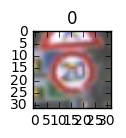

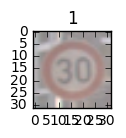

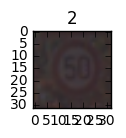

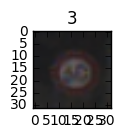

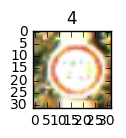

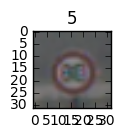

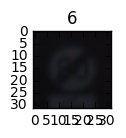

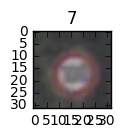

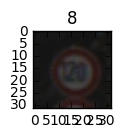

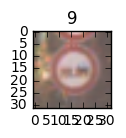

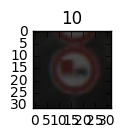

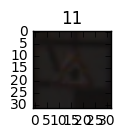

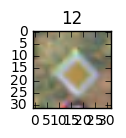

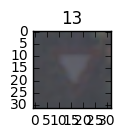

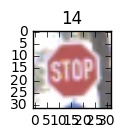

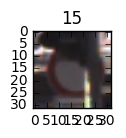

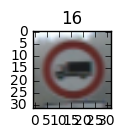

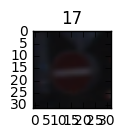

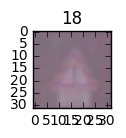

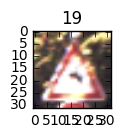

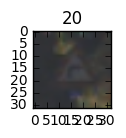

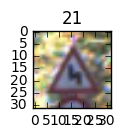

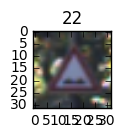

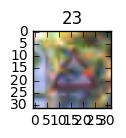

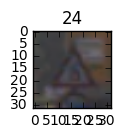

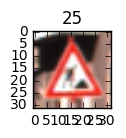

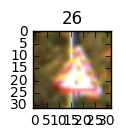

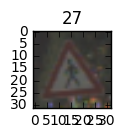

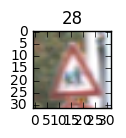

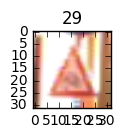

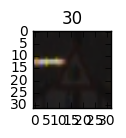

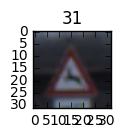

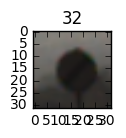

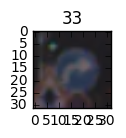

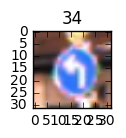

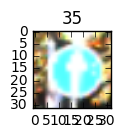

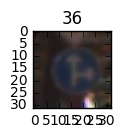

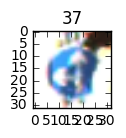

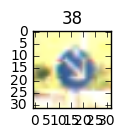

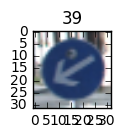

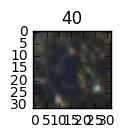

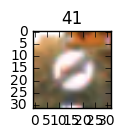

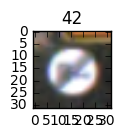

In [3]:
# Data exploration 
# Let’s take a look at a sample image

import random
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

print('Show an example of each traffic sign in set, in order from 0 to 42')

u, indices = np.unique(y_train, return_index=True)
for label, index in zip(u, indices):
    image = X_train[index].squeeze()
    plt.figure(figsize=(1,1))
    plt.title(label)
    plt.imshow(image)
    

----

## Step 2: Design and Test a Model Architecture


In [4]:
# Preprocess the data.
import cv2

from sklearn.utils import shuffle

def shuffle_data(X_train, y_train):
    X_train, y_train = shuffle(X_train, y_train)
    return X_train, y_train

# normalize pixel values of input images across all channels.
def normalize_images(X_train):
    X_train = X_train.astype('float32')
    return X_train/255. - .5


For preprocessing I normalized the pixel values that range in values [0, 255] to [-.5, .5] and shuffled the sets. I tried Histogram Equalization using OpenCV and converting to grey scale and back but this process gave slightly worse results than just simple normalisation. So I opted for the simpler approach.

In [5]:
# Split the data into training/validation/testing sets here.

# Training set has already been pulled separately: X_train, y_train.

# split test set into test/validation sets.
from sklearn.model_selection import train_test_split
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.20, random_state=42)


# Generate additional data
# By rotating or warping images in training set.

import cv2

def rotate_images(X_train, y_train, stop=1):
    for i in range(stop):
        # grab the image
        image = X_train[i]
        # get dimensions of image and calculate center
        (h, w) = image.shape[:2]
        center = (w / 2, h / 2)
        # rotate the image by either -25 or 25 degrees.
        angle = random.choice([-25, 25])
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        # add to set
        X_train = np.append(X_train, [rotated], axis=0)
        y_train = np.append(y_train, [y_train[i]], axis=0)
    return X_train, y_train

def warp_images(X_train, y_train, start=0, stop=1):
    for i in range(start, stop, 1):
        # get image
        image = X_train[i]
        # get dimensions of image
        rows,cols,ch = image.shape
        # calculate transform
        # warp randomly 1 of 2 different ways.
        chg_pts = random.choice([[[4, 8],[24, 6],[10, 30]], [[10, 10],[24, 6],[8, 28]]])
        pts1 = np.float32([[6, 6],[24, 6],[6, 24]])
        pts2 = np.float32(chg_pts)
        # perform transform and warp
        M = cv2.getAffineTransform(pts1,pts2)
        warped = cv2.warpAffine(image,M,(cols,rows))
        # add to set
        X_train = np.append(X_train, [warped], axis=0)
        y_train = np.append(y_train, [y_train[i]], axis=0)
    return X_train, y_train

# Additional images did not increase accuracy, will not add to Training set.
#X_train, y_train = rotate_images(X_train, y_train,stop=10000)
#X_train, y_train = warp_images(X_train, y_train, start=10000, stop=20000)
print(len(X_train))
        
# Check to make sure all sets have corresponding labels.
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

# shuffle training set.
X_train, y_train = shuffle_data(X_train, y_train)

# normalize training, testing and validation sets.
X_train = normalize_images(X_train)
X_test = normalize_images(X_test)
X_validation = normalize_images(X_validation)


39209


The training and testing sets were provided separately. I initially added 10,000 additional signs to the training set by either rotating the images + 25 or - 25 degrees (anymore than this I thought could potentially change the meaning of the sign). I also initially added another 10,000 signs by warping some of the signs as well, just 2 different ways (which to me, merely shifted the perspective of the signs a bit). For a total of 20,000 additonal signs. But after running the Neural Net it did not seem to matter at all, so I commented out the creation of these images. Additonally, I sliced off 20% of the testing set for validation purposes.

In [6]:
# Neural net Architecture based on LeNet.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
  
    # Arguments for tf.truncated_normal: weights & biases matrices, initialized randomly with normal distribution
    mu = 0
    sigma = 0.1
     
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x3x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 32), mean = mu, stddev = sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(32), name='conv1_b')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Rectilinear Unit Activation.
    conv1 = tf.nn.relu(conv1)    
    # Local Response Normaliztion
    conv1 = tf.nn.local_response_normalization(conv1)
    # Max Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(64), name='conv2_b')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b    
    # Rectilinear Unit Activation.
    conv2 = tf.nn.relu(conv2)    
    # Local Response Normaliztion
    conv2 = tf.nn.local_response_normalization(conv2)
    # Max Pooling. Input = 10x10x64. Output = 4x4x64. 
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 4x4x64. Output = 1024.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1024. Output = 480.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 480), mean = mu, stddev = sigma), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(480), name='fc1_b')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    # Rectilinear Unit Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 480. Output = 168.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(480, 168), mean = mu, stddev = sigma), name='fc2_W')
    fc2_b  = tf.Variable(tf.zeros(168), name='fc2_b')
    fc2    = tf.matmul(fc1_drop, fc2_W) + fc2_b    
    # Rectilinear Unit Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2_drop = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 168. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(168, 43), mean = mu, stddev = sigma), name='fc3_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='fc3_b')
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    # save to collection for restoring model variables
    tf.add_to_collection('vars', conv1_W)
    tf.add_to_collection('vars', conv1_b)
    tf.add_to_collection('vars', conv2_W)
    tf.add_to_collection('vars', conv2_b)
    tf.add_to_collection('vars', fc1_W)
    tf.add_to_collection('vars', fc1_b)
    tf.add_to_collection('vars', fc2_W)
    tf.add_to_collection('vars', fc2_b)
    tf.add_to_collection('vars', fc3_W)
    tf.add_to_collection('vars', fc3_b)
    
    return logits

My final Neural Net architecure consists of 2 convolutional layers and 3 fully connected layers - and this was based upon the LeNet architecture. I tested an additional layer but it did not seem to yield greater accuracy through 10 epochs. In additon I made some changes to this architecture, using what seemed to be a highly influential paper - ImageNet Classification with Deep Convolutional Neural Networks by Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. The changes I made were as follows: I added Local Response Normalization in each of the convolutional layers. I also per their recommendation used a larger ksize= 3 than stride size= 2 in the max pooling. Testing both of these features did increase the accuracy on average through 10 epochs than without. I started with 32 feature maps and I used a dropout of .5 on the first 2 fully connected layers.

In [7]:
# Training Model
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
# keep probablity for drop out.
keep_prob = tf.placeholder(tf.float32)

# normally just use one_hot_y = tf.one_hot(y, 43), but known issue with tensor flow for windows

with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, 43)

# training rate.

rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, '.\lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.756

EPOCH 2 ...
Validation Accuracy = 0.910

EPOCH 3 ...
Validation Accuracy = 0.932

EPOCH 4 ...
Validation Accuracy = 0.951

EPOCH 5 ...
Validation Accuracy = 0.963

EPOCH 6 ...
Validation Accuracy = 0.962

EPOCH 7 ...
Validation Accuracy = 0.963

EPOCH 8 ...
Validation Accuracy = 0.968

EPOCH 9 ...
Validation Accuracy = 0.972

EPOCH 10 ...
Validation Accuracy = 0.971

EPOCH 11 ...
Validation Accuracy = 0.971

EPOCH 12 ...
Validation Accuracy = 0.974

EPOCH 13 ...
Validation Accuracy = 0.976

EPOCH 14 ...
Validation Accuracy = 0.973

EPOCH 15 ...
Validation Accuracy = 0.975

EPOCH 16 ...
Validation Accuracy = 0.978

EPOCH 17 ...
Validation Accuracy = 0.970

EPOCH 18 ...
Validation Accuracy = 0.978

EPOCH 19 ...
Validation Accuracy = 0.972

EPOCH 20 ...
Validation Accuracy = 0.972

EPOCH 21 ...
Validation Accuracy = 0.976

EPOCH 22 ...
Validation Accuracy = 0.981

EPOCH 23 ...
Validation Accuracy = 0.980

EPOCH 24 ...
Validation Accura

I used the Adamoptimizer (which typically provides better results than the GradientDescentOptimizer). I used batch sizes of 128 on 100 epochs. I used a learning rate of .0005 and I tried a slower learning rate of .0001 but this did not seem to work any better over 20 epochs. Additionaly, I initialized the training weights on a truncated normal distribution with mu of 0 and a sigma .1. The biases were initialized to 0. 


In [8]:
#Test data

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.976


My general approach in coming up with this solution was to use the basic LeNet architecture plus I read up on several optimization tips presented in papers, specifically the paper mentioned earlier. And then it was just trial and error from there. Keeping aspects that seemed to increase the accuracy and discarding aspects that did not. Specifically, I first changed the number of feature maps created from the LeNet Architecure 6 to 18. This increased the accuracy and from there I tried increasing the number of convolutional layers from 2 to 3. But this did not yield better results through 10 epochs so I reversed tack and reduced the number of convolutional layers back down to 2 and next increased the number of feature maps from 18 to 32. This increased the accuracy so I next added the local response normalization which seemed to have a positive effect as well. Next I changed the max pooling ksize from 2 to 3 and left the Max Pooling Stride at 2, which as described in the paper mentioned above did have a positive effect. Finally I added the dropout of .5 to the training set and once again, this yielded good results. My main rational was to use the LeNet architecture, since it was a designed to be used for image recogniton and then use internet searches to find ways to optimize this architecture for my current problem. I read a few papers and websites, but the one I based most of my changes on was the one that seemed to be highest ranked of the papers in my search. I did not use the same architecture as the paper cited since my training set was much smaller and the number of features was far less and I did not have as much time to train as they did in their paper. Plus as I already mentioned additional convolutional layers did not seem to give better results. 

---

## Step 3: Test Model on Found Images


Load Images:

(5, 32, 32, 3)


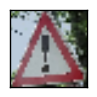

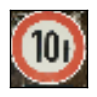

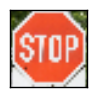

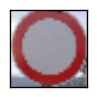

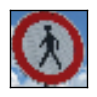

In [9]:
# Load the images and plot them here.

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

# images from Internet cropped and reduced in size
img = cv2.imread('Zeichen_201+1006-39.jpeg')
b,g,r = cv2.split(img)       # get b,g,r
img = cv2.merge([r,g,b])     # switch it to rgb
rsi1 = cv2.resize(img, (32,32))

img2 = cv2.imread('Verkehrszeichen_2924.jpg')
b,g,r = cv2.split(img2)       # get b,g,r
img2 = cv2.merge([r,g,b])     # switch it to rgb
rsi2 = cv2.resize(img2, (32,32))

img3 = cv2.imread('Verkehrsschilder_3601.jpg')
b,g,r = cv2.split(img3)       # get b,g,r
img3 = cv2.merge([r,g,b])     # switch it to rgb
rsi3 = cv2.resize(img3, (32,32))

img4 = cv2.imread('Solingen_Burg_-_Seilbahn_30_ies.jpg')
b,g,r = cv2.split(img4)       # get b,g,r
img4 = cv2.merge([r,g,b])     # switch it to rgb
rsi4 = cv2.resize(img4, (32,32))

img5 = cv2.imread('Sichertshausen_Lahn-Hochwasser_Lahntalradweg_(Germany)_2015-12-06_(2).jpg')
b,g,r = cv2.split(img5)       # get b,g,r
img5 = cv2.merge([r,g,b])     # switch it to rgb
rsi5 = cv2.resize(img5, (32,32))

img6 = cv2.imread('Dienstweg.jpg')
b,g,r = cv2.split(img6)       # get b,g,r
img6 = cv2.merge([r,g,b])     # switch it to rgb
rsi6 = cv2.resize(img6, (32,32))


# create list of images found on internet search.
images = [rsi1, rsi2, rsi4, rsi5, rsi6]

# print 5 images.

for i in images:
    plt.figure(figsize=(3,1))
    plt.imshow(i)
    plt.xticks([]), plt.yticks([])   # to hide tick values on X and Y axis
    plt.show
    
# normalize found images
imgs = np.array(images)
imgs = normalize_images(imgs)
print(imgs.shape)

The images I chose were from a google search on the internet. They are cropped versions of larger pictures. I think this severly degraded their quality. But we'll see if this makes a difference. One of the images - the second one - doesn't really have a corresponding label but it's close to other speed limit signs.

In [10]:
# Run the predictions here.

# Use 5 candidate images - New Images.
img_labels = np.array([18,1,14,15,27]) # correct labels for found images.


predict = tf.argmax(logits, 1)

with tf.Session() as sess:
    
    loader = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    all_vars = tf.get_collection('vars')
    for v in all_vars:
        v_ = sess.run(v)
    predictions = sess.run(predict, feed_dict={x: imgs, keep_prob: 1.0})
    print(predictions)
    
    
    

[18  1 14 15 40]


My model predicted the results pretty well. About 80%. This isn't nearly as good as is did on the test set 97.6% but I think this is because I had to crop the images I found on the internet which caused them to be pixelated. Additionaly, the second image is a speed limit of 10. There is no label for a speed limit of 10. But it did predict that it is a speed limit 30, maybe it should have predicted a speed limit of 20. Pretty close. I'm surprised it didn't properly identify the last label - the pedestrian sign.

In [21]:
# Visualize the softmax probabilities here.

top = tf.nn.top_k(logits, 5)



with tf.Session() as sess:
    
    loader = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    all_vars = tf.get_collection('vars')
    for v in all_vars:
        v_ = sess.run(v)
    top5s = sess.run(top, feed_dict={x: imgs, keep_prob: 1.0})
    print(top5s)
    

TopKV2(values=array([[  5.02907982e+01,  -3.08101249e+00,  -7.18780136e+00,
         -1.12752161e+01,  -1.19240828e+01],
       [  1.18870478e+01,   1.92575216e+00,   4.70053963e-03,
         -2.26269007e+00,  -2.61757588e+00],
       [  2.63198414e+01,   1.89949763e+00,   1.37882900e+00,
          9.17318821e-01,   7.06758916e-01],
       [  2.37228966e+01,   9.80827272e-01,   4.03654188e-01,
         -1.05673194e+00,  -1.17559385e+00],
       [  6.31381559e+00,   4.83826786e-01,  -3.58939648e-01,
         -7.79037118e-01,  -3.05776310e+00]], dtype=float32), indices=array([[18, 26, 27, 28, 39],
       [ 1,  4,  2,  0, 24],
       [14,  3,  5,  8, 29],
       [15,  4,  2,  8,  9],
       [40,  4, 27, 18, 26]]))


My model, which correctly identified 4 out of 5 images (the first 4). Is very certain of the 1st and 4th images. And to a lesser extent the 2nd and 3rd images. As already explained the 2nd image is not really in the data set. But it's a speed limit and if we look at it's top five it includes 3 additional speed limit signs. So I would say that's fairly accurate. The last image which was incorrectly identified shows the correct label with the 3rd highest probability. I'm pretty happy with that. I think I could increase my model's real world accuracy by augmenting the dataset. Even though I tried to augment the dataset (and it didn't give better results), I think it was because I did not change the images enough and my classifier started to overfit with the additional images.  